# Chapter 03 - Statistical Experiments and Significance Testing 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## A/B Testing

An A/B test is an experiment with two groups to establish which of two treatments, products, procedures, or the like is superior. Often one of the two treatments is the standard existing treatment, or no treatment. If a standard (or no) treatment is used, it is called the control. A typical hypothesis is that a new treatment is better than the control.

## Hypothesis Tests

The purpose of a hypothesis test is to help you learn whether random chance might be responsible for an observed effect. An A/B test is constructed based on a hypothesis.

Important concepts in the hypothesis test framework is the null and the alternative hypothesis. The null hypothesis represents the status quo of a situation. It is essentially what we want to disprove. Meanwhile, the alternative hypothesis represents what we want to prove.

The hypothesis test is performed using the model as if the null hypothesis is true. Then, it is evaluated if the outcome of the experiment is a reasonable outcome of that model.

## Resampling

Resampling in statistics means to repeatedly sample values from observed data, with the goal of **assessing random variability** in a statistic.

There are two main types of resampling: **the bootstrap** (see chapter 02 notebook) and **permutation tests**.

- The bootstrap is used to assess the reliability of an estimate.
- Permutation tests are used to test hypothesis.

### Permutation Test

"The first step in a permutation test of a hypothesis is to combine the results from groups A and B (and, if used, C, D, ...). This is the logical embodiment of the null hypothesis that the treatments to which the groups were exposed do not differ. We then test that hypothesis by randomly drawing groups from this combined set and seeing how much they differ from one another.

The procedure of a permutation test is as follows:

1. Combine the results from the different groups into a single data set.
2. Shuffle the combined data and then randomly draw (**without replacement**) a resample of the same size as group A (clearly it will contain some data from the other groups).
3. From the remaining data, randomly draw (**without replacement**) a resample of the same size as group B.
4. Do the same for groups C, D, and so on. You have now collected one set of resamples that mirror the sizes of the original samples.
5. Whatever statistic or estimate was calculated for the original samples (e.g., difference in group proportions), calculate it now for the resamples, and record; this constitutes one permutation iteration.
6. Repeat the previous steps R times to yield a permutation distribution of the test statistic.

With the permutation distribution, we can go back to the observed difference between groups and compare it to the set of permuted differences. If the difference is statistiscally significant, we have successfully disproved the null hypothesis.

### Example: Web Stickiness

**Problem setup**

A company selling a relatively high-value service wants to test which of two web presentations does a better selling job. Due to the high value of the service being sold, sales are infrequent and the sales cycle is lengthy; it would take too long to accumulate enough sales to know which presentation is superior. So the company decides to measure the results with a proxy variable, using the detailed interior page that describes the service.

One potential proxy variable for our company is the number of clicks on the detailed landing page. A better one is how long people spend on the page. It is reasonable to think that a web presentation (page) that holds people’s attention longer will lead to more sales. Hence, our metric is average session time, comparing page A to page B.

In [2]:
session_times = pd.read_csv("../data/web_page_data.csv")
session_times.Time = 100 * session_times.Time

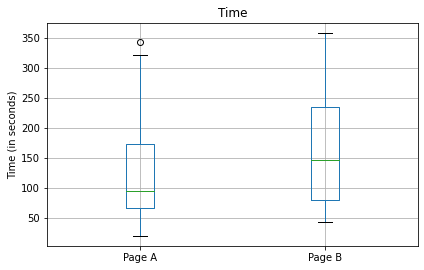

In [3]:
ax = session_times.boxplot(by="Page", column="Time")
ax.set_xlabel("")
ax.set_ylabel("Time (in seconds)")
plt.suptitle("")

plt.tight_layout()
plt.show()

In [4]:
mean_a = session_times[session_times["Page"] == "Page A"]["Time"].mean()
mean_b = session_times[session_times["Page"] == "Page B"]["Time"].mean()

In [5]:
mean_b - mean_a

35.66666666666667

We can see that the average session time of page B is greater than for page A by 35.67 seconds. The question if whether this difference is within the range of what random chance might produce. To answer that, we are going to use a permutation test.

In [6]:
import random

def permutation_fn(times, size_a, size_b):
    size = size_a + size_b
    idx_b = set(random.sample(range(size), size_b))
    idx_a = set(range(size)) - idx_b
    return times.loc[list(idx_b)].mean() - times.loc[list(idx_a)].mean()

In [7]:
# get the permutation distribution
counts = session_times["Page"].value_counts()
size_a, size_b = counts["Page A"], counts["Page B"]

np.random.seed(1)
perm_diffs = [permutation_fn(session_times.Time, size_a, size_b) for _ in range(1000) ]

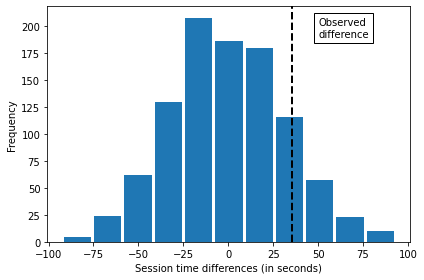

In [8]:
fig, ax = plt.subplots(1, 1)

ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x = mean_b - mean_a, color = "black", lw=2, linestyle="--")
ax.text(50, 190, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Session time differences (in seconds)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In the histogram we can see that the mean difference of random permutations often exceeds the observed difference in session times (vertical line), and this happens 12.1% of the time as computed below:

In [9]:
# p-value of the permutation test
np.mean(perm_diffs > mean_b - mean_a)

0.126

Therefore, we have evidence that the observed difference in session time between page A and page B is well within the range of chance variation and thus **is not statistically significant**.

### Extra: Hypothesis Test using classical framework

We performed a permutation test and verified that the results are not statistically significant. But one question I'm curious about is: what if I performed another test? So now, let's perform a classical hypothesis test. 

We want to check wheter the average session time for presentation B is greater than for presentation A. This setup characterizes a 2-sample 1-tailed t-test.


Our hypothesis will be

- $H_0$: $\mu_b - \mu_a = 0$
- $H_1$: $\mu_b - \mu_a > 0$

In [10]:
# some descriptive statistics about the two samples
session_times.groupby("Page").describe()

Time                                                         
       count        mean         std   min   25%    50%    75%    max
Page                                                                 
Page A  21.0  126.333333   88.463175  21.0  67.0   95.0  173.0  342.0
Page B  15.0  162.000000  101.136400  43.0  80.0  147.0  234.5  357.0

A regular t-test statistic would be computed like this:

$$
t = \frac{\mu_b - \mu_a}{SE} \text{, where $SE = \frac{s}{\sqrt{n}}$ is the standard error}. 
$$

As we are interested in the statistics describing the variance between the two samples, we need to take into account the standard errors of both samples. By assumption, we determine that the variances are equal, so we pool the standard errors using the following equation:

$$
SE_p = \sqrt{\frac{s_a^2}{n_a} + \frac{s_b^2}{n_b}}
$$

and the degrees of freedom of the t distribution is $df = n_1 + n_2 - 2$.

In [11]:
std_a = session_times[session_times["Page"] == "Page A"]["Time"].std()
std_b = session_times[session_times["Page"] == "Page B"]["Time"].std()

se_p = np.sqrt(std_a**2 / size_a + std_b**2 / size_b)
t_statistic = (mean_b - mean_a) / se_p

degrees_freedom = size_a + size_b - 2
t_critical = 1.307

In [12]:
t_statistic

1.098315562363811

In [13]:
t_statistic < t_critical

True

Since our test statistic is less than the critical value of the t-distribution at 10% significance level, we fail to reject the null hypothesis that there is no statistical difference between the sample means.

Another way to check this result is to build a confidence interval around the mean of the difference between the means using the formula showed in the previous chapter:

$$
\bar{x} \pm t_{34}(0.1) \frac{s}{\sqrt{n}}
$$

In [14]:
lower, upper = [(mean_b - mean_a) - t_critical*se_p, (mean_b - mean_a) + t_critical*se_p]

In [15]:
lower, upper

(-6.776812175611568, 78.11014550894491)

As the lower bound is a negative number, and the upper bound is a positive number, the confidence encompass zero indicating that zero (our hypothesized difference) is a valid estimate of the mean difference between the two samples. This conclusion is obviously the same as the previous test, and we would treat our null hypothesis in the same way.

In addition, we can also compute the p-value for this test statistic:

In [16]:
# comput p-value
from scipy import stats

stats.t.sf(t_statistic, df=degrees_freedom)

0.13989195118925815

As the result suggests, the evidence is that results are not statistically significant at the 10% significance level of the test.

## Statistical Significance and p-Values

Statistical significance is how statisticians measure whether an experiment (or even a study of existing data) yields a result more extreme than what chance might produce.

Important concepts to keep in mind in this setting are:

**p-value**
Given a model built under the null hypothesis, i.e. assuming the null is true, the p-value is the probability of obtaining results as unusual or extreme as the observed results.

**alpha**
The probability threshold of “unusualness” that chance results must surpass for actual outcomes to be deemed statistically significant.

Now consider the following dataset 

| outcome | Price A | Price B |
|---------|---------|---------|
| conversion | 200 | 182 |
| No conversion | 23539 | 22406 |

displaying the results of the web test discussed ealier with presentations A and B. Price A converts almost 5% better than price B ($0.8425\% = 200/(23539+200)*100$, versus $0.8057\% = 182/(22406+182)*100$ - a difference of 0.0368 percentage points), big enough to be meaningful in a high-volume business.

The following permutation procedure asks, "If the two prices share the same conversion rate, could chance variation produce a difference as big as 5%?":


1. Put cards labeled 1 and 0 in a box: this represents the supposed shared conversion rate of 382 ones and 45,945 zeros = 0.008246 = 0.8246%.
2. Shuffle and draw out a resample of size 23,739 (same n as price A), and record how many 1s.
3. Record the number of 1s in the remaining 22,588 (same n as price B).
4. Record the difference in proportion of 1s.
5. Repeat steps 2–4.
6. How often was the difference $\ge$ 0.0368?

In [17]:
obs_pct_diff = 100 * (200 / 23759 - 182 / 22588)
obs_pct_diff

0.036048710699681207

In [18]:
conversion = [0] * 45945
conversion.extend([1] * 382)
conversion = pd.Series(conversion)

In [19]:
np.random.seed(1)
perm_diffs = [100 * permutation_fn(conversion, 23739, 22588) for _ in range(1000)]

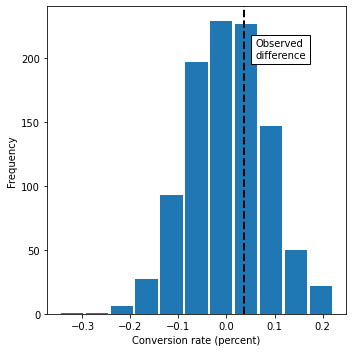

In [20]:
fig, ax = plt.subplots(figsize=(5, 5))

ax.hist(perm_diffs, bins=11, rwidth=0.9)
ax.axvline(x=obs_pct_diff, color='black', lw=2, linestyle="--")
ax.text(0.06, 200, 'Observed\ndifference', bbox={'facecolor':'white'})
ax.set_xlabel('Conversion rate (percent)')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

As it happens, in this case the observed difference of 0.0360% is well within the range of chance variation.

### p-value

Simply looking at the distribution might be tricky some times. A better way of assessing statistical significance is using the p-value. The p-value of a permutation test is computed by taking the proportion of times that the permutation test produces a difference equal to or greater than the observed difference.

In [21]:
np.mean([diff > obs_pct_diff for diff in perm_diffs])

0.338

The p-value is 0.31, which means that we would expect to achieve a result as extreme as this, or a more extreme result, by random chance over 31% of the time.

In [22]:
survivors = np.array([[200, 23739 - 200], [182, 22588 - 182]])
chi2, p_value, df, _ = stats.chi2_contingency(survivors)

print(f'p-value for single sided test: {p_value / 2:.4f}')

p-value for single sided test: 0.3498


The normal approximation yields a p-value of 0.3498, which is close to the p-value obtained from the permutation test.

## t-Tests

In a resampling test, the scale of the data does not matter. You create the reference (null hypothesis) distribution from the data itself and use the test statistic as is. However, resampling test waw not practical in the early 20th century. Moreover, Statisticians found that a **good approximation to the permutation (shuffled) distribution was the t-test**, based on Gosset’s t-distribution. It is used for the very common two-sample comparison—A/B test—in which the data is numeric.



In [23]:
from scipy import stats

res = stats.ttest_ind(session_times[session_times["Page"] == "Page A"]["Time"],
                      session_times[session_times["Page"] == "Page B"]["Time"],
                      equal_var=False)

print(f'p-value for single sided test: {res.pvalue / 2:.4f}')

p-value for single sided test: 0.1408


The p-value of 0.1408 is close to the permutation test p-value of 0.121.

In [24]:
res

Ttest_indResult(statistic=-1.098315562363811, pvalue=0.2815243724570061)

## ANOVA

Suppose that instead of an A/B test, we wanted to compare multiple groups, say A/B/C/D, each with numeric data. The procedure that tests for statistical significance difference among groups is called analysis of variance, or ANOVA.

In [25]:
four_sessions = pd.read_csv("../data/four_sessions.csv")

In [28]:
four_sessions.head()

,Page,Time
0,Page 1,164
1,Page 2,178
2,Page 3,175
3,Page 4,155
4,Page 1,172


In [31]:
four_sessions.groupby("Page").mean()

,Time
Page,
Page 1,172.8
Page 2,182.6
Page 3,175.6
Page 4,164.6


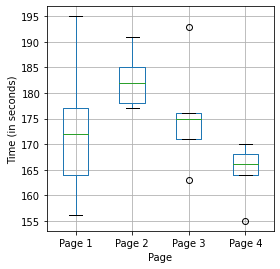

In [30]:
ax = four_sessions.boxplot(by='Page', column='Time',
                           figsize=(4, 4))
ax.set_xlabel('Page')
ax.set_ylabel('Time (in seconds)')
plt.suptitle('')
plt.title('')

plt.tight_layout()
plt.show()

To make comparisons between groups, we could perform a pairwise comparison. However, there are six pairwise combinations of groups. The more such pairwise comparisons we make, the greater the potential for being fooled by random chance. So, we could perform just one test that addresses the question: 

"Could all the pages have the same underlying stickiness, and the differences among them be due to the ran‐
dom way in which a common set of session times got allocated among the four pages?"

The procedure used to test this is ANOVA. The basis for it can be seen in the following resampling procedure (specified here for the A/B/C/D test of web page stickiness):

1. Combine all the data together in a single box.
2. Shuffle and draw out four resamples of five values each. 
3. Record the mean of each of the four groups.
4. Record the variance among the four group means.
5. Repeat steps 2–4 many (say, 1,000) times.

The p-value is given by the proportion of the time that the resampled variance exceeded the observed variance.

In [36]:
observed_variance = four_sessions.groupby("Page").mean().var()[0]

print('Observed means:', four_sessions.groupby('Page').mean().values.ravel())
print('Variance:', observed_variance)

Observed means: [172.8 182.6 175.6 164.6]
Variance: 55.426666666666655


In [37]:
def permutation_test_anova(data):
    data = data.copy()
    data["Time"] = np.random.permutation(data["Time"].values)
    return data.groupby("Page").mean().var()[0]

In [39]:
np.random.seed(1)
permutation_var = [permutation_test_anova(four_sessions) for _ in range(3000)]
print('Pr(Prob)', np.mean([var > observed_variance for var in permutation_var]))

Pr(Prob) 0.08433333333333333


Therefore, under the 5% significance level, we failed to reject the null hypothesis of the test.

### F-Statistic

**Just like the t-test can be used instead of a permutation test for comparing the mean of two groups, there is a statistical test for ANOVA based on the F-statistic**. The F-statistic is based on the ratio of the variance across group means (i.e., the treatment effect) to the variance due to residual error. The higher this ratio, the more statistically significant the result.

In [40]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

In [41]:
model = smf.ols("Time ~ Page", data=four_sessions).fit()

aov_table = sm.stats.anova_lm(model)
aov_table

,df,sum_sq,mean_sq,F,PR(>F)
Page,3.0,831.4,277.133333,2.739825,0.077586
Residual,16.0,1618.4,101.150000,NaN,NaN


In [43]:
# F value
aov_table["mean_sq"][0] / aov_table["mean_sq"][1]

2.739825341901452

Note that the p-value for the F-test, 0.0776 is closer to the one obtained using ANOVA, 0.0843. Both tests failed to reject the Null Hypothesis under 5% confidence level.

The key ideias from this section are:

- ANOVA is a statistical procedure for analyzing the results of an experiment with multiple groups.
- It is the extension of similar procedures for the A/B test, used to assess whether the overall variation among groups is within the range of chance variation.

## Chi-Square Test

The chi-square test is used with count data to test how well it fits some expected distribution. The most common use of the chi-square statistic in statistical practice is with r × c (rows by columns) contingency tables, to assess whether the null hypothesis of independence among variables is reasonable.

### Chi-Square Test: A Resampling  Approach

In [45]:
click_rate = pd.read_csv("../data/click_rates.csv")
clicks = click_rate.pivot(index='Click', columns='Headline', values='Rate')
clicks

Headline,Headline A,Headline B,Headline C
Click,,,
Click,14,8,12
No-click,986,992,988


A resampling procedure can test whether the click rates differ to an extent greater than chance might cause. We can perform the test using this resampling algorithm:

1. Constitute a box with 34 ones (clicks) and 2,966 zeros (no clicks).
2. Shuffle, take three separate samples of 1,000, and count the clicks in each.
3. Find the squared differences between the shuffled counts and the expected counts and sum them.
4. Repeat steps 2 and 3, say, 1,000 times.
5. How often does the resampled sum of squared deviations exceed the observed? That’s the p-value.

In [47]:
box = [1] * 34
box.extend([0] * 2966)
random.shuffle(box)

def chi2(observed, expected):
    pearson_residuals = []
    for row, expect in zip(observed, expected):
        pearson_residuals.append([(observe - expect) ** 2 / expect
                                  for observe in row])
    # return sum of squares
    return np.sum(pearson_residuals)

expected_clicks = 34 / 3
expected_noclicks = 1000 - expected_clicks
expected = [34 / 3, 1000 - 34 / 3]
chi2observed = chi2(clicks.values, expected)

def perm_fun(box):
    sample_clicks = [sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000)),
                     sum(random.sample(box, 1000))]
    sample_noclicks = [1000 - n for n in sample_clicks]
    return chi2([sample_clicks, sample_noclicks], expected)

perm_chi2 = [perm_fun(box) for _ in range(2000)]

resampled_p_value = sum(perm_chi2 > chi2observed) / len(perm_chi2)
print(f'Observed chi2: {chi2observed:.4f}')
print(f'Resampled p-value: {resampled_p_value:.4f}')

Observed chi2: 1.6659
Resampled p-value: 0.4810


The results suggests that it is reasonable to think that chance may produce the values we observed. 

### Chi-Square Test: Statistical Theory

Asymptotic statistical theory shows that the distribution of the chi-square statistic can be approximated by a chi-square distribution.

In [48]:
chisq, pvalue, df, expected = stats.chi2_contingency(clicks)
print(f'Observed chi2: {chisq:.4f}')
print(f'p-value: {pvalue:.4f}')

Observed chi2: 1.6659
p-value: 0.4348


The values of the `observed chi2` test were computed using `stats.chi2_contingency` function, which uses the chi-square distribution to compute the p-value. Note that the p-value is a little less than the resampling p-value. That is due to the fact that the chi-square distribution is only an approximation of the actual distribution of the statistic.

### Fisher's Exact Test

The chi-square distribution is a good approximation of the shuffled resampling test just described, except when counts are extremely low (single digits, especially five or fewer). In such cases, the resampling procedure will yield more accurate p-values. In fact, most statistical software has a procedure to actually enumerate all the possible rearrangements (permutations) that can occur, tabulate their frequencies, and determine exactly how extreme the observed result is. This is called Fisher’s exact test after the great statistician R. A. Fisher.